**Рассмотрены 2 подхода прогнозирования временных рядов:**

**1) с помощью байесовской модели из модуля Pydlm**

**2) библиотеки от Facebook Prophet**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
from fbprophet import Prophet
from pydlm import dlm, trend, seasonality, dynamic

Importing plotly failed. Interactive plots will not work.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [67]:
PREDICTIONS = 4

Чтение данных

In [68]:
df = pd.read_csv('extra_1.csv',';', parse_dates=True, dayfirst=True)
df['fact'] = df['fact'].astype(float)
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df = df.sort_values(by=['date'], ascending=True).reset_index(drop=True)
df.head(2)

,date,fact,prediction,prev
0,2015-05-06,1.503,-0.117,-0.066
1,2015-05-13,-2.503,0.829,1.503


Посмотрим на данные непосредственно

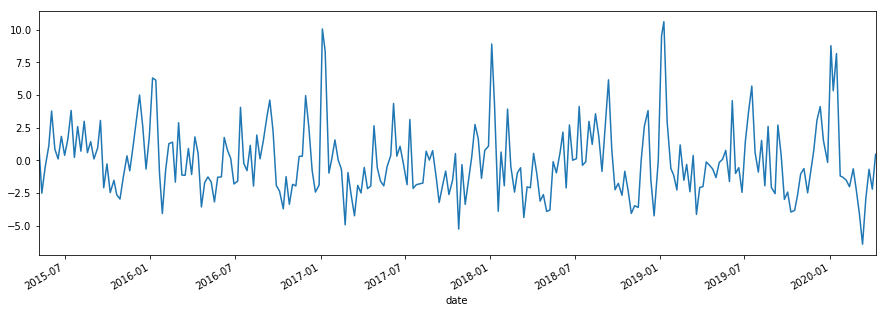

In [69]:
df_ar = df[['date', 'fact']].set_index('date')
plt.figure(figsize(15,5))
df_ar['fact'].plot()
plt.show()

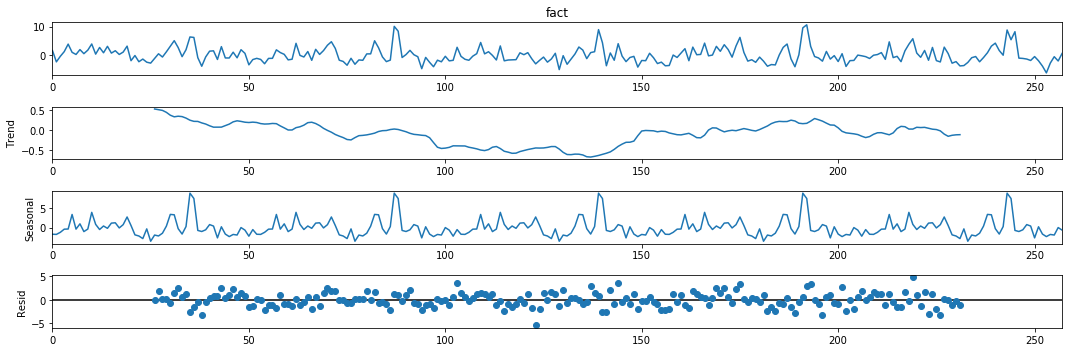

In [70]:
sm.tsa.seasonal_decompose(df['fact'], period=52).plot()
plt.show()

## Prophet

In [71]:
#подготовка датафрейма
df_prop = df[['date', 'fact']].copy().rename(columns={'date': 'ds', 'fact': 'y'})

train_df = df_prop[:-PREDICTIONS].copy()
test_df = df_prop[-PREDICTIONS:].copy()

In [72]:
print(test_df.shape)
test_df.tail()

(4, 2)


,ds,y
254,2020-03-18,-2.940
255,2020-03-25,-0.679
256,2020-04-01,-2.194
257,2020-04-08,0.476


In [73]:
prop_model = Prophet()
prop_model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [74]:
future = prop_model.make_future_dataframe(periods=PREDICTIONS, freq='W', include_history=False)
future.tail()

,ds
0,2020-03-15
1,2020-03-22
2,2020-03-29
3,2020-04-05


Видно, что даты съехали, соберем их непосредственно сами

In [75]:
future = test_df[['ds']]
forecast_prop = prop_model.predict(future)

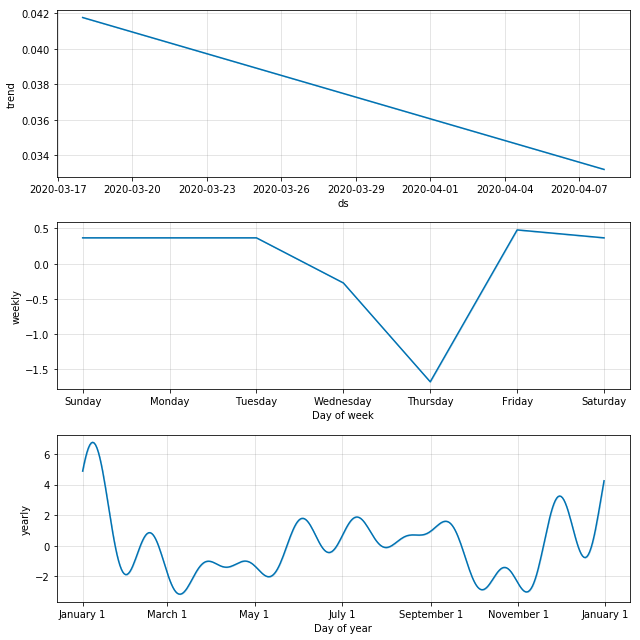

In [77]:
prop_model.plot_components(forecast_prop)
plt.show()

In [78]:
cmp_df = forecast_prop.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_prop.set_index('ds'))
cmp_df.head(1)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-03-18,-2.447114,-4.76703,-0.008286,-2.94


In [79]:
mse = np.mean((cmp_df.iloc[-PREDICTIONS:, 0] - cmp_df.iloc[-PREDICTIONS:, 3])**2)
print(f"Накопленный квадрат ошибок: {mse}")

Накопленный квадрат ошибок: 1.4741452265918478


##  Bayesian model

In [89]:
#возьмем значения для обучения из сделанного для prophet датафрейма
time_series = train_df['y']

In [90]:
trend_ = trend(degree=0, discount=0.99, name='trend_', w=10)
seasonal52 = seasonality(period=52, discount=0.99, name='seasonal52', w=10)

In [91]:
dlm_model = dlm(time_series) + trend_ + seasonal52
dlm_model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


<Figure size 1080x720 with 0 Axes>

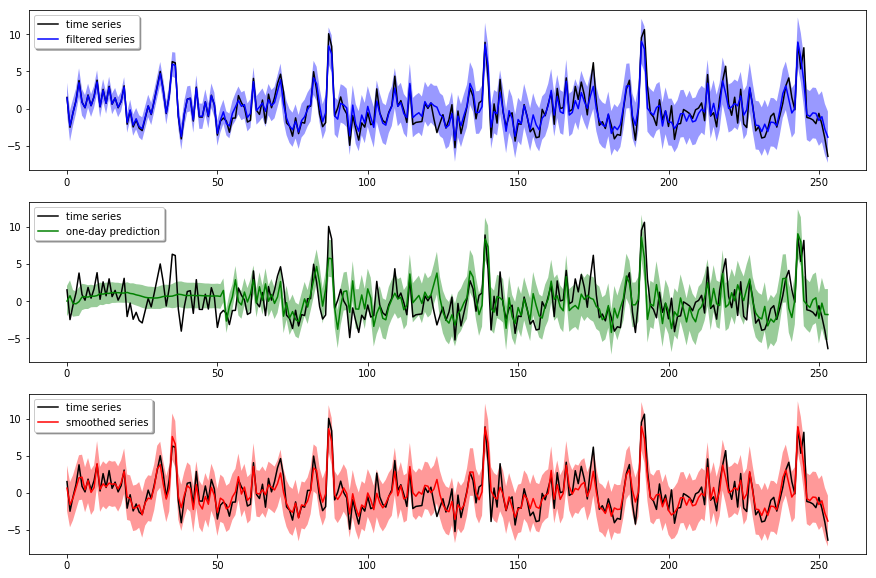

In [92]:
# Plot the fitted results
plt.figure(figsize(15,10))
dlm_model.turnOff('data points')
dlm_model.plot()

<Figure size 1080x288 with 0 Axes>

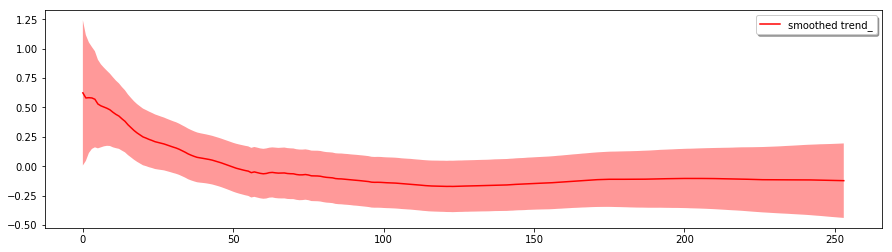

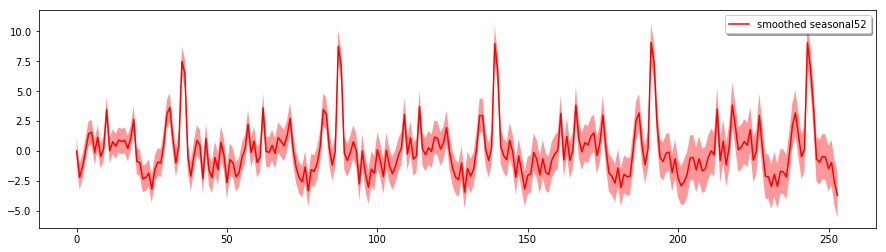

In [93]:
# Plot each component
plt.figure(figsize(15,4))
dlm_model.turnOff('predict plot')
dlm_model.turnOff('filtered plot')
dlm_model.plot('trend_')
dlm_model.plot('seasonal52')

In [94]:
forecast_dlm = dlm_model.predictN(PREDICTIONS)[0]

In [95]:
mse = np.mean((df['fact'][-PREDICTIONS:] - forecast_dlm)**2)
print(f"Накопленный квадрат ошибок: {mse}")

Накопленный квадрат ошибок: 1.3583493346103965


##  Графики с предсказаниями

In [105]:
date_list = df.index[-PREDICTIONS:]
data = pd.DataFrame(columns = ['dlm', 'prophet', 'fact'], index=date_list)
data['dlm'] = forecast_dlm
data['fact'] = df['fact'][-PREDICTIONS:]
data['prophet'] = cmp_df.iloc[-PREDICTIONS:, 0].values

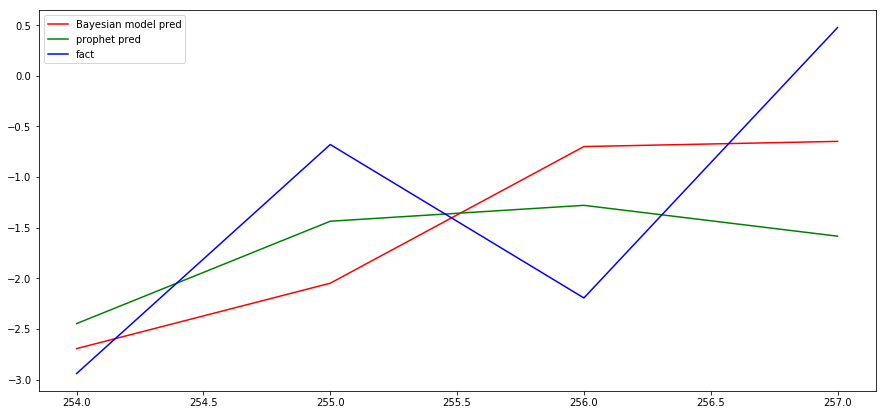

In [108]:
plt.figure(figsize(15,7))

plt.plot(date_list, data['dlm'], color='r', label='Bayesian model pred')
plt.plot(date_list, data['prophet'], color='g', label='prophet pred')
plt.plot(date_list, data['fact'], color='b', label='fact')

plt.legend(loc='best')
plt.show()

## Графики накопленных квадартов ошибок

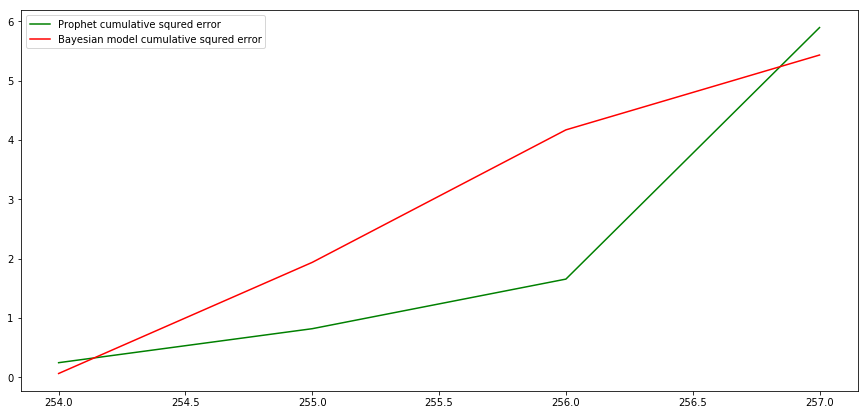

In [107]:
plt.plot(np.cumsum((data['prophet'] - data['fact'])**2), color='g'
        , label='Prophet cumulative squred error')
plt.plot(np.cumsum((data.loc[:, 'dlm'] - data.loc[:, 'fact'])**2), color='r'
        , label='Bayesian model cumulative squred error')
plt.legend(loc='best');

## Вывод:
Байесовская модель с учетом тренда и сезонности предсказывает лучше на данном временном ряде с заданным интервалом предсказания, что видно исходя из накопленного квадрата ошибок как в численном, так и в графическом виде, а также из вида кривых предсказаний и истинного значения.

В задаче предсказывается временной ряд на месяц на недельных данных.

Примечательно то, что, начиная с некоторого горизнота прездсказания, модель prophet будет лучше.